In [375]:
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense


from tcn import TCN

# Inverting representations

This section introduces the computation of an approximate
inverse of a time series representation. This is formulated
as the problem of finding a time series whose representation
best matches the one given.

## I/ Representation to be inverted

### 1/ The original time-serie

In [376]:
df = pd.read_csv('all_stocks_5yr.csv', delimiter=',', usecols=['date', 'close', "Name"])
df_AAPL = df.query("Name == 'AAPL'")
df_AAPL.head(-1)

,date,close,Name
1259,2013-02-08,67.8542,AAPL
1260,2013-02-11,68.5614,AAPL
1261,2013-02-12,66.8428,AAPL
1262,2013-02-13,66.7156,AAPL
1263,2013-02-14,66.6556,AAPL
...,...,...,...
2512,2018-01-31,167.4300,AAPL
2513,2018-02-01,167.7800,AAPL
2514,2018-02-02,160.5000,AAPL
2515,2018-02-05,156.4900,AAPL


In [377]:
pd.options.plotting.backend = "plotly"
df_AAPL.plot(x='date', y='close')

In [378]:
column_indices = {name: i for i, name in enumerate(df_AAPL.columns)}

n = len(df_AAPL)
train_df = df_AAPL[0:int(n*0.7)]
val_df = df_AAPL[int(n*0.7):int(n*0.9)]
test_df = df_AAPL[int(n*0.9):]

num_features = df.shape[1]

In [379]:
close_aapl_train = train_df['close'].values
close_aapl_val = val_df['close'].values
close_aapl_test = test_df['close'].values
print("Shapes:")
print("train", close_aapl_train.shape)
print("val", close_aapl_val.shape)
print("test",close_aapl_test.shape)

Shapes:
train (881,)
val (252,)
test (126,)


### 2/ The representation (TCN)

In [380]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, InputLayer,
                                     Conv1D, MaxPool1D)

In [381]:
lookback_window = 12

In [382]:
# split a univariate sequence into samples
def split_sequence(sequence, window_size):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + window_size
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [383]:
X_train, y_train = split_sequence(close_aapl_train, lookback_window)
X_val, y_val = split_sequence(close_aapl_val, lookback_window)
X_test, y_test = split_sequence(close_aapl_test, lookback_window)

In [384]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [385]:
model = Sequential()
model.add(InputLayer(input_shape=[lookback_window, 1]))
for dilation_rate in (1, 2, 4, 8):
    model.add(
      Conv1D(filters=64,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(Conv1D(filters=64, kernel_size=1))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(192, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

In [386]:
"""
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[lookback_window, 1]))
model.add(TCN())
model.add(keras.layers.Reshape((64, 1), input_shape=(64, )))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1, activation='relu', input_shape=(1, 1)))
model.add(keras.layers.AveragePooling1D(pool_size=64))
model.add(keras.layers.Reshape((1, ), input_shape=(1, 1)))
"""

"\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.InputLayer(input_shape=[lookback_window, 1]))\nmodel.add(TCN())\nmodel.add(keras.layers.Reshape((64, 1), input_shape=(64, )))\nmodel.add(keras.layers.Conv1D(filters=1, kernel_size=1, activation='relu', input_shape=(1, 1)))\nmodel.add(keras.layers.AveragePooling1D(pool_size=64))\nmodel.add(keras.layers.Reshape((1, ), input_shape=(1, 1)))\n"

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 12, 64)            192       
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 12, 64)            8256      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 12, 64)            8256      
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 12, 64)            8256      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 12, 64)            4160      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 384)             

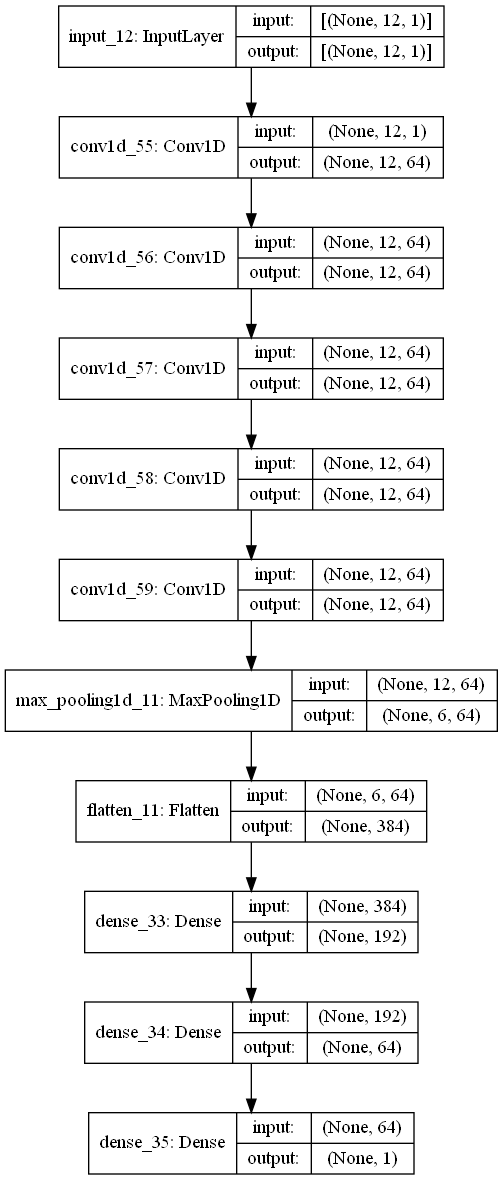

In [387]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### 3/ The representation of the time serie

Depending on the task and type of model we may want to generate a variety of data windows. For examples:

1. For example, to make a single prediction 24 days into the future, given 24 days of history, we might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one day into the future, given six days of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

### 4/ Training the representation

In [388]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [389]:
print('Train...')
history = model.fit(X_train,
                    y_train, 
                    epochs=100,
                    validation_data=(X_val, y_val))

Train...
Epoch 1/100
28/28 [==============================] - 2s 26ms/step - loss: 3976.9862 - mean_absolute_error: 52.4454 - val_loss: 314.2953 - val_mean_absolute_error: 17.1238
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 81.5550 - mean_absolute_error: 7.2578 - val_loss: 16.1810 - val_mean_absolute_error: 3.1650
Epoch 3/100
28/28 [==============================] - 0s 8ms/step - loss: 18.2116 - mean_absolute_error: 3.3482 - val_loss: 17.2598 - val_mean_absolute_error: 3.3071
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 14.6275 - mean_absolute_error: 2.9741 - val_loss: 15.6579 - val_mean_absolute_error: 3.1021
Epoch 5/100
28/28 [==============================] - 0s 8ms/step - loss: 15.0859 - mean_absolute_error: 3.0043 - val_loss: 15.1484 - val_mean_absolute_error: 3.0327
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 15.8705 - mean_absolute_error: 3.0795 - val_loss: 16.5012 - val_mean_absolute_error: 3.

In [390]:
import matplotlib.pyplot as plt

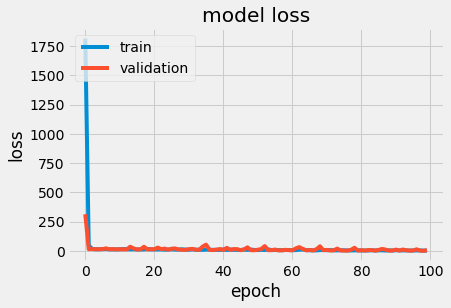

In [391]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [392]:
predict = model.predict(X_test)

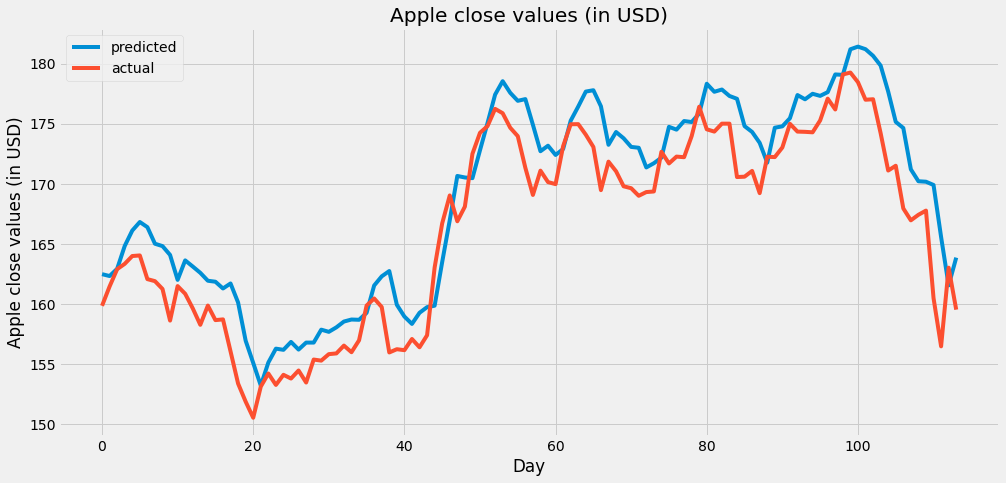

In [393]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,7))
plt.plot(predict)
plt.plot(y_test)
plt.title('Apple close values (in USD)')
plt.legend(['predicted', 'actual'])
plt.xlabel("Day")
plt.ylabel("Apple close values (in USD)")
plt.show()

### Inversion

Let's try to inverse an encodage of a time serie by the representation. For example:

array([162.49226], dtype=float32)

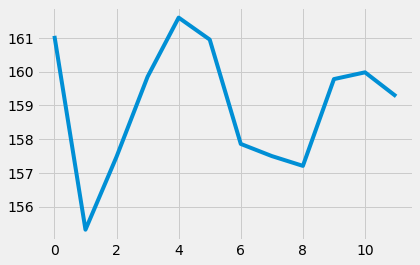

In [394]:
ground_truth, phi_0 = X_test[0], predict[0] # Ground truth and the representation to be inverted
plt.plot(ground_truth)
phi_0

### 3/ Loss function

In [395]:
test = model.predict(ground_truth.reshape((1, 12, 1)))
test

array([[162.49225]], dtype=float32)

In [396]:
def loss(preds, target):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(target, preds).numpy()

### 4/ Regulariser

In [397]:
def regulariser(x, alpha=6):
    return np.linalg.norm(x, alpha)

## II/ Optimisation

In [398]:
from scipy.optimize import minimize

In [399]:
def func(x):
    return loss(model.predict(x.reshape((1, 12, 1))), phi_0)

In [400]:
theta_noise = 100
start = np.random.randn(12) + ground_truth.mean()
start = start.reshape((1, 12, 1))
start_zeros = np.zeros(12).reshape((1, 12, 1))
start_ones = np.ones(12).reshape((1, 12, 1))

In [401]:
res = minimize(func, x0=start)

In [402]:
res.x

array([158.5549037 , 157.8776902 , 159.00090702, 158.85446989,
       160.13449665, 159.54176908, 157.19569447, 158.82973602,
       158.41703064, 160.41392522, 160.19044575, 158.82253719])

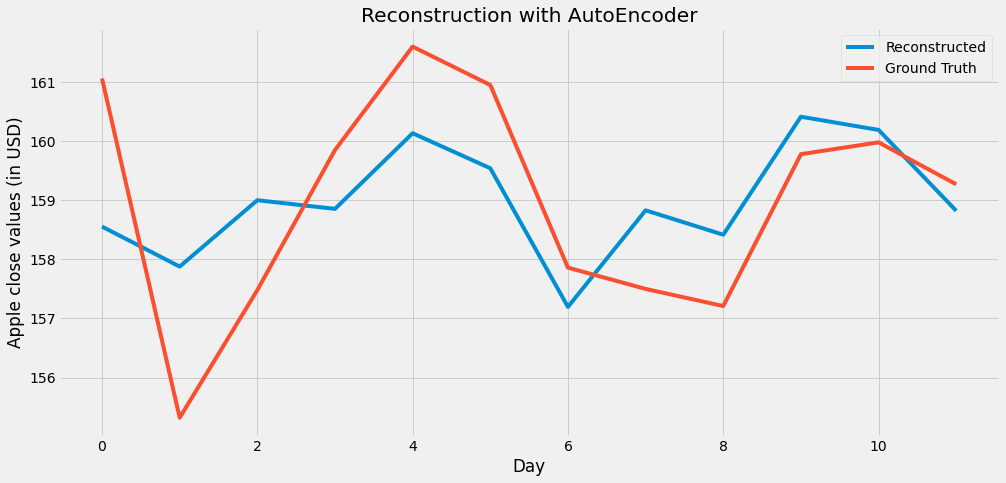

In [403]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,7))
plt.plot(res.x)
plt.plot(ground_truth)
plt.title('Reconstruction with AutoEncoder')
plt.legend(['Reconstructed', 'Ground Truth'])
plt.xlabel("Day")
plt.ylabel("Apple close values (in USD)")
plt.show()

## III/ Feature Optimization

In [404]:
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
layer_names

['conv1d_55',
 'conv1d_56',
 'conv1d_57',
 'conv1d_58',
 'conv1d_59',
 'max_pooling1d_11',
 'flatten_11',
 'dense_33',
 'dense_34',
 'dense_35']

In [405]:
successive_outputs = [layer.output for layer in model.layers]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

In [406]:
successive_feature_maps = visualization_model.predict(ground_truth.reshape((1, 12, 1)))

(1, 12, 64)
conv1d_55
(1, 12, 64)
conv1d_56
(1, 12, 64)
conv1d_57
(1, 12, 64)
conv1d_58
(1, 12, 64)
conv1d_59
(1, 6, 64)
max_pooling1d_11
(1, 384)
flatten_11
(1, 192)
dense_33
(1, 64)
dense_34
(1, 1)
dense_35


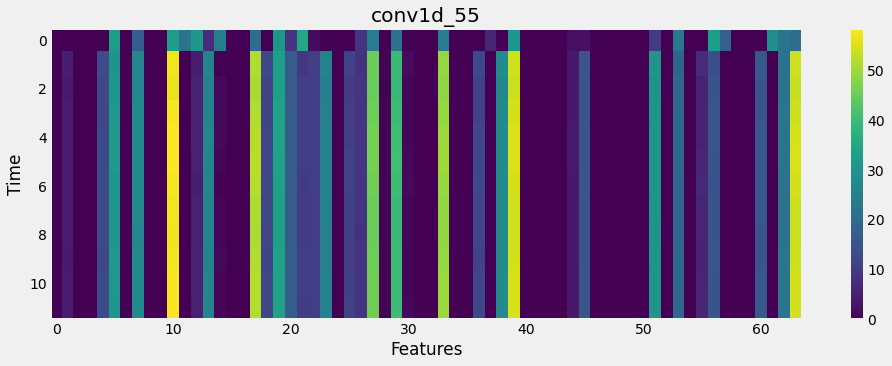

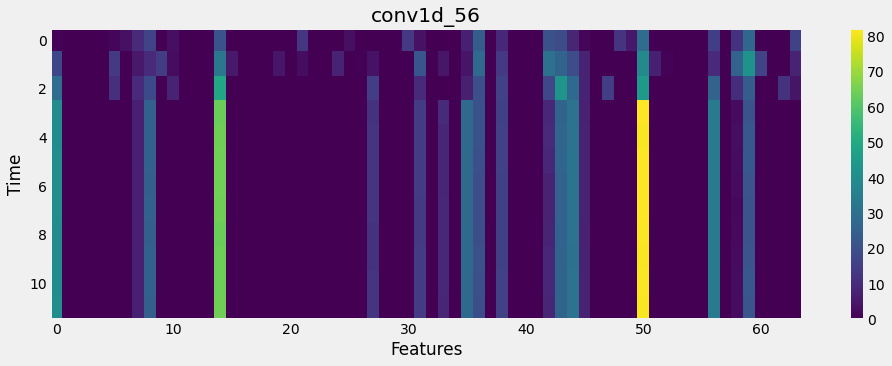

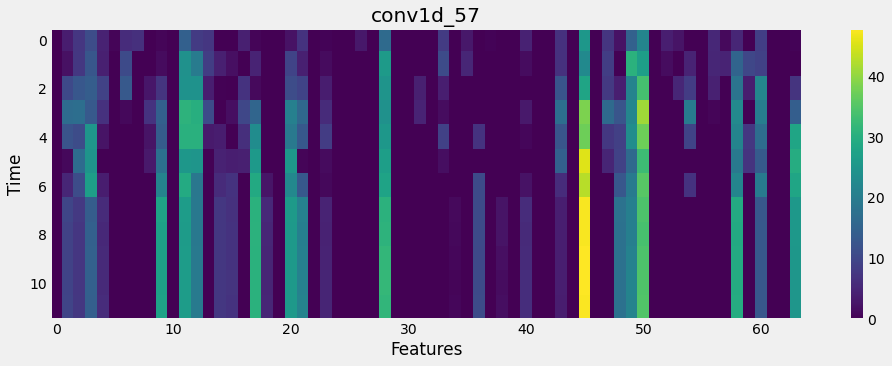

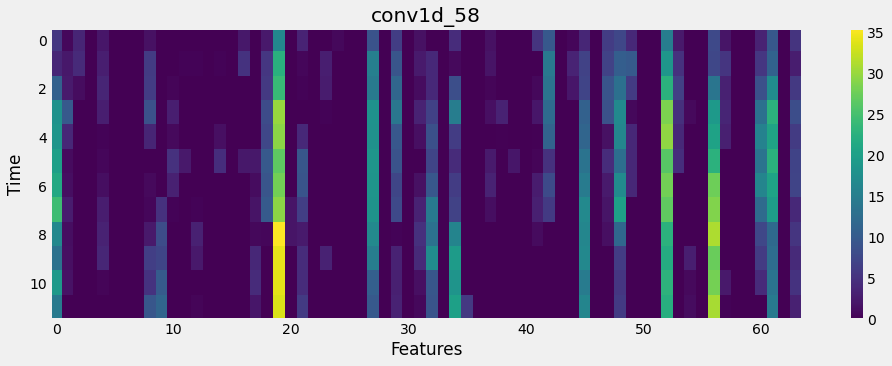

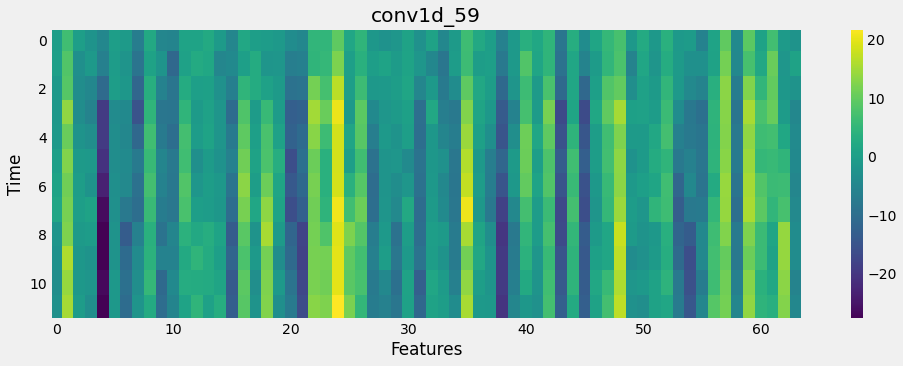

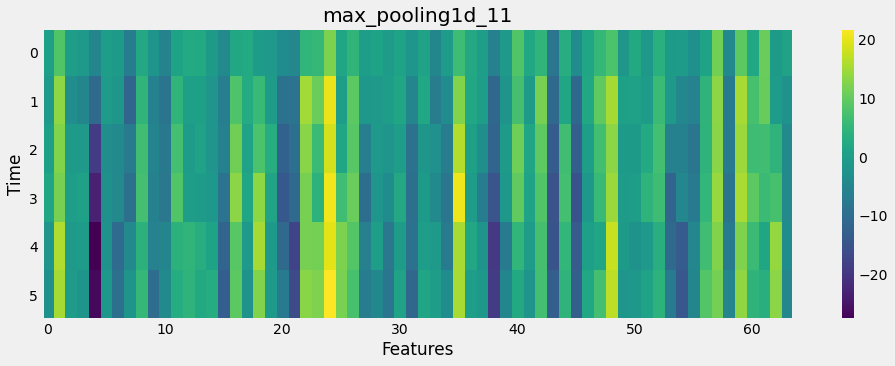

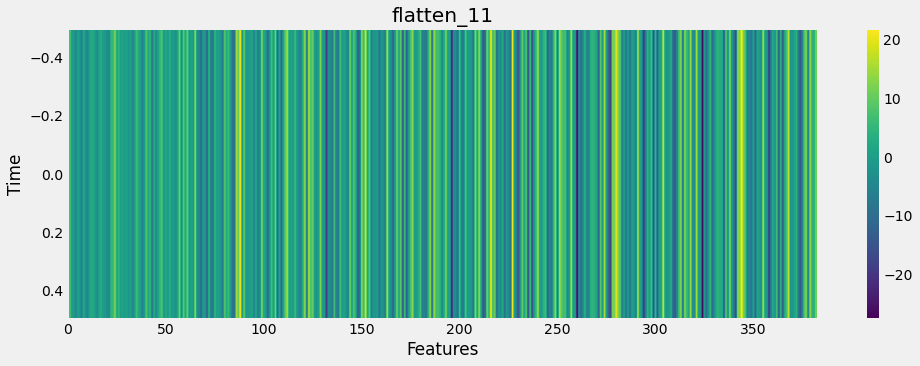

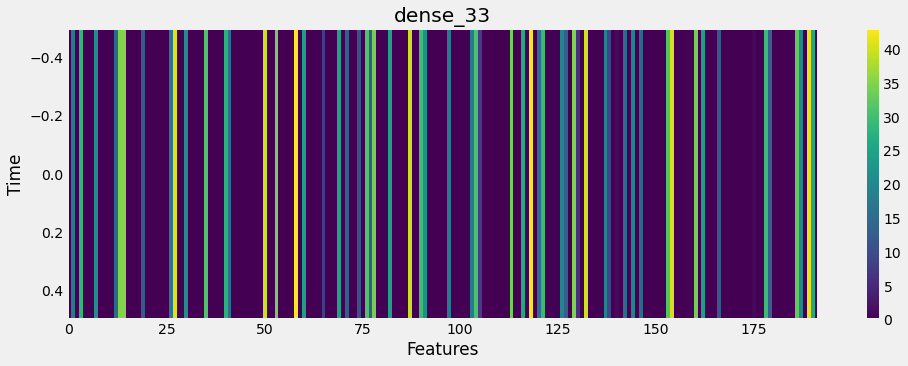

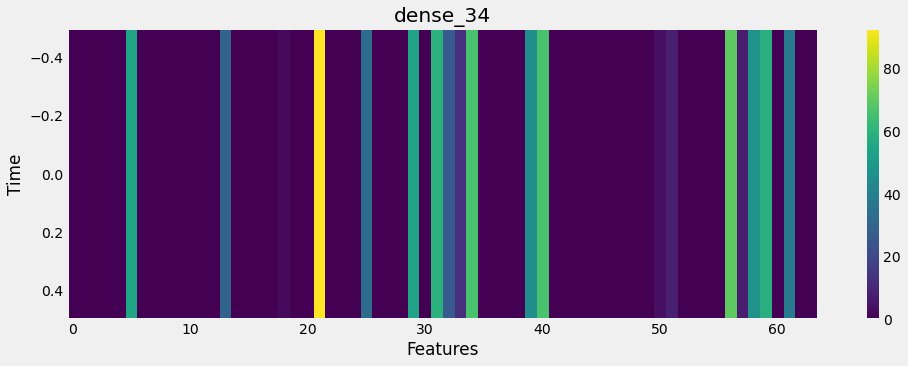

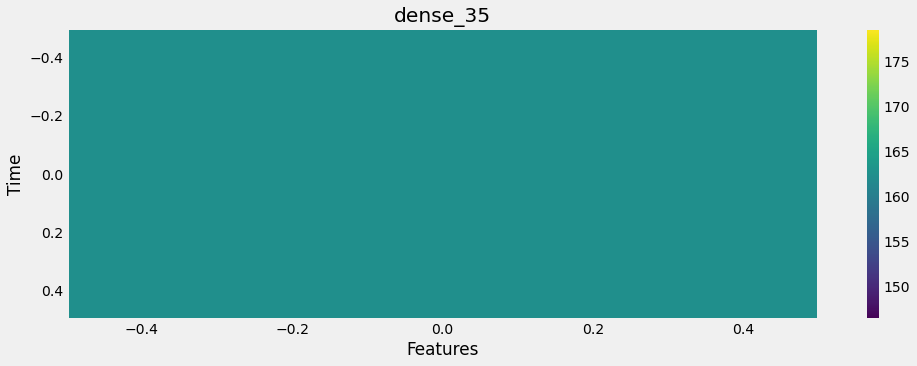

In [407]:
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  print(layer_name)
  if len(feature_map.shape) == 2:
    n_features = feature_map.shape[-1]
    plt.figure( figsize=(15, 5) )
    plt.title ( layer_name )
    plt.xlabel("Features")
    plt.ylabel("Time")
    plt.grid  ( False )
    plt.imshow(feature_map, aspect='auto', cmap='viridis' )
    plt.colorbar()
  else:
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers 
  # Display the grid
    plt.figure( figsize=(15, 5) )
    plt.title ( layer_name )
    plt.xlabel("Features")
    plt.ylabel("Time")
    plt.grid  ( False )
    plt.imshow(feature_map[0, :, :], aspect='auto', cmap='viridis' )
    plt.colorbar()

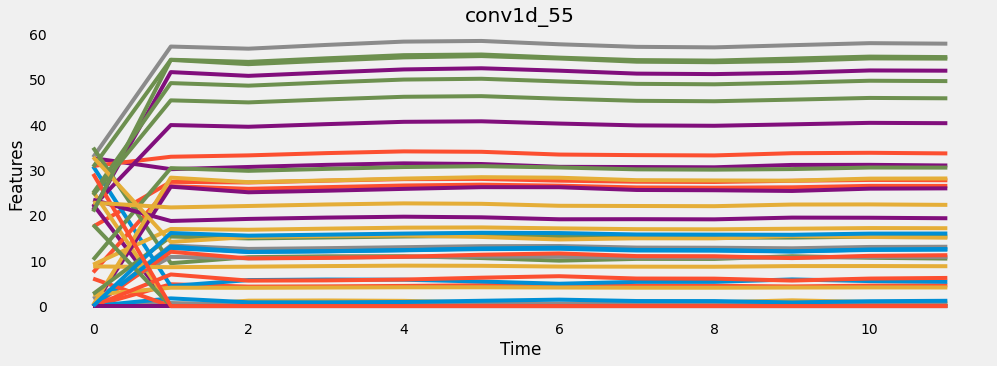

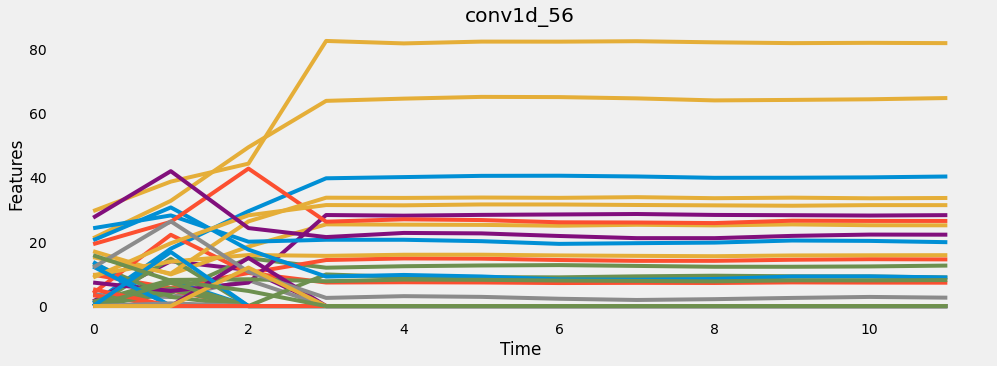

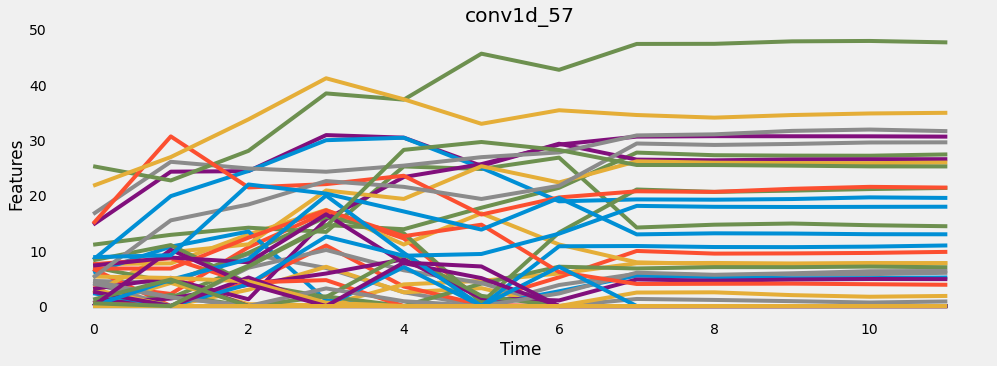

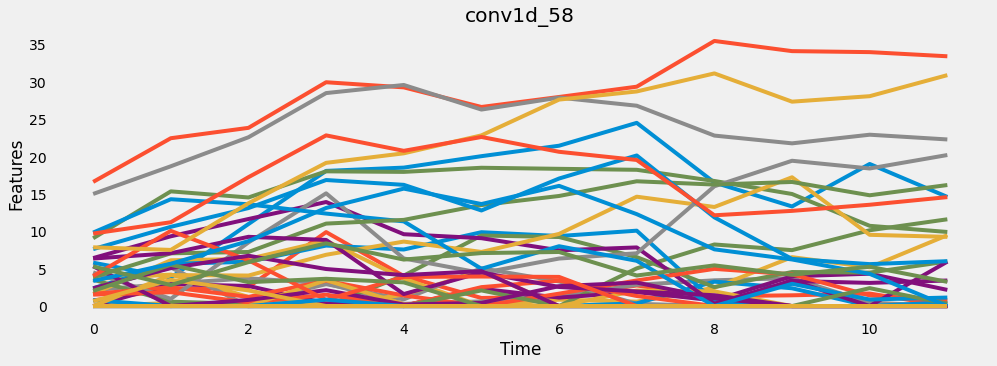

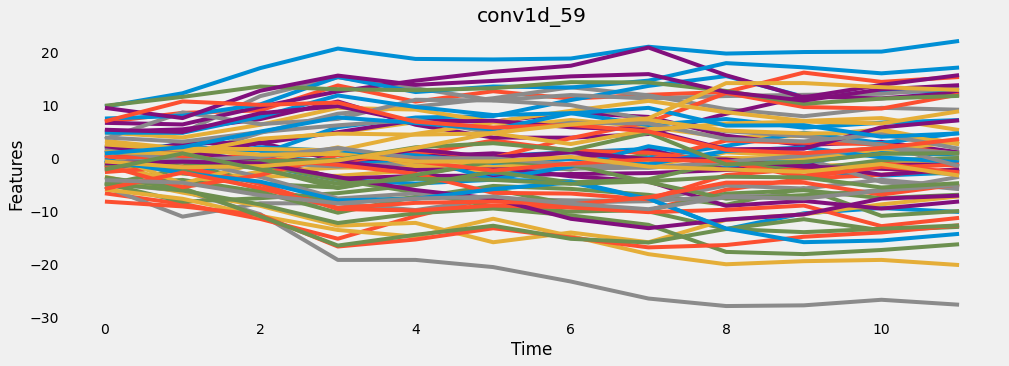

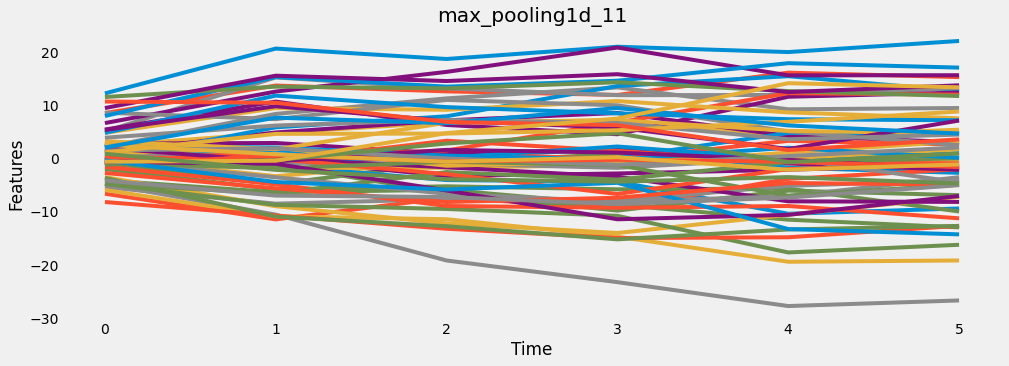

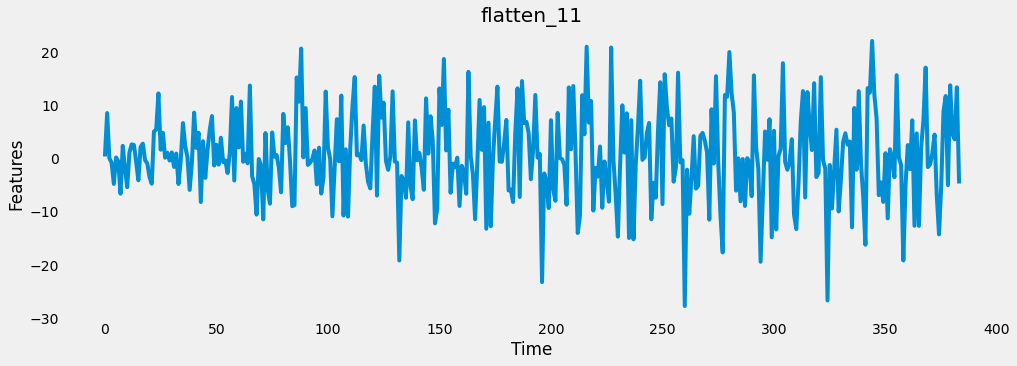

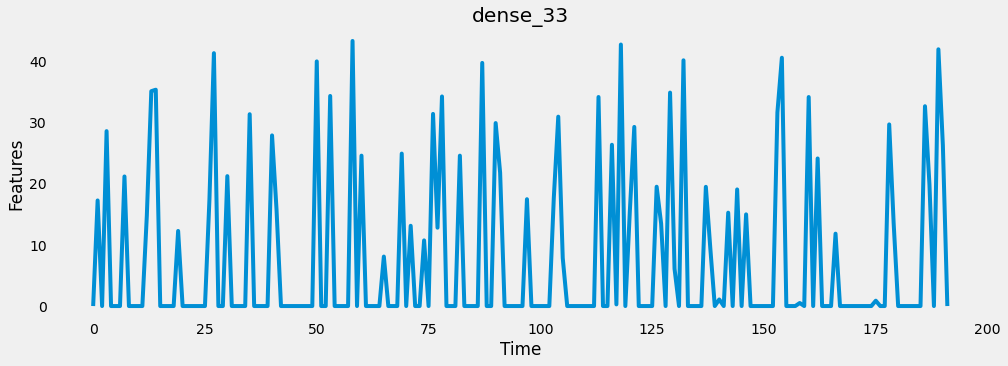

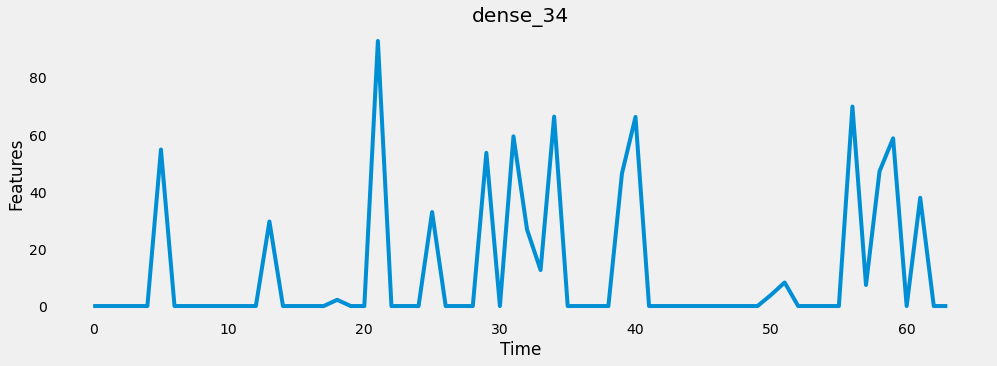

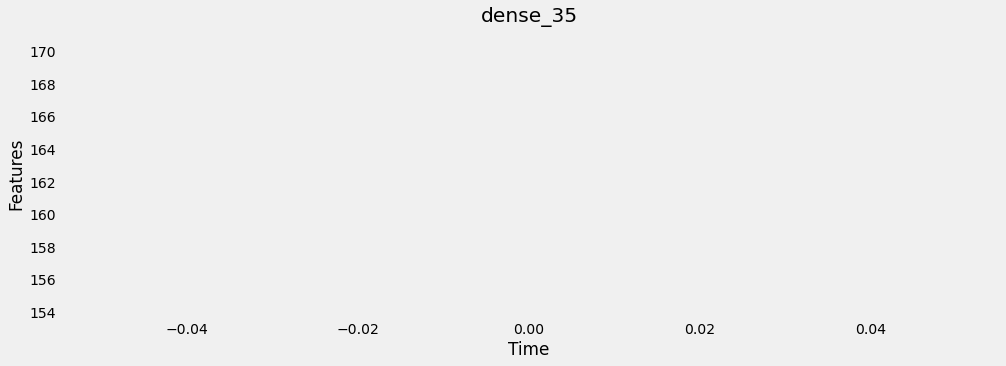

In [408]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    plt.figure( figsize=(15, 5) )
    plt.title ( layer_name )
    plt.xlabel("Time")
    plt.ylabel("Features")
    plt.grid  ( False )
    plt.plot(feature_map[-1])